In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
# do the inline thing
%matplotlib inline

import seaborn as sns

from lcfunctions import download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
from outlier import iqr_method, reorder_cols

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from raw_processing import label_schemes

from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [98]:
cvlistdate = '21032023'
lightcurvesdate = '08102023'
label_scheme = 'labels_2'
gaia = True

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_{cvlistdate}allfeatures_inc_labels{lightcurvesdate}.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
# drop rows with no Gaia data
# dataset = dataset[dataset['ra_error'].notna()].reset_index(drop=True)
# dataset = dataset[dataset['absmag_g'].notna()].reset_index(drop=True)

# Drop Gaia features
if gaia == False:
    dataset = dataset.iloc[:,:-34]

# Filter dataset
dataset_pts_threshold = dataset[(dataset['n_obs_g']>=20) & (dataset['n_obs_r']>=20)].reset_index(drop=True)
# dataset_timespan_threshold = dataset[dataset['temporal_baseline_g']>=365].reset_index(drop=True)

# Dataset going forward
dataset_final = dataset

print(dataset_final[label_scheme].value_counts())

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


0 ZTF18abgjgiq


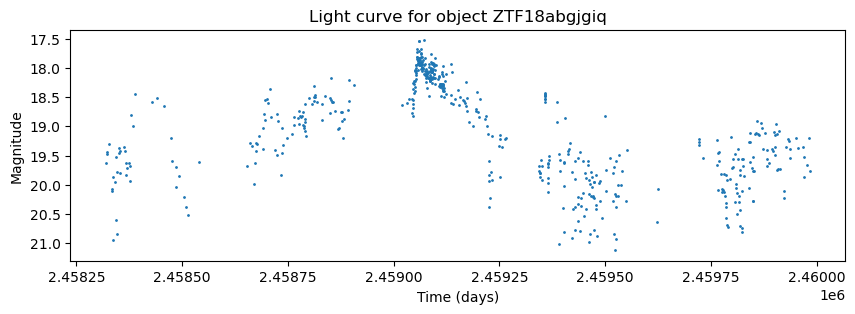

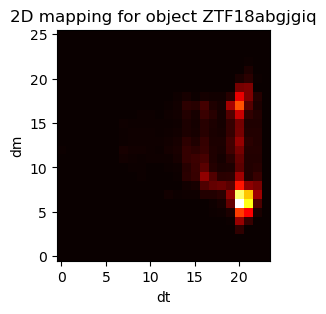

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def create_2d_mapping(light_curve_df, filter='g'):
    # Extract magnitude and time values from the light curve
    df_g = light_curve_df[light_curve_df['fid'] == 1].reset_index(drop=True)
    df_r = light_curve_df[light_curve_df['fid'] == 2].reset_index(drop=True)

    if filter == 'g':
        magnitudes = np.array(df_g['dc_mag'].values)
        times = np.array(df_g['jd'].values)
    elif filter == 'r':
        magnitudes = np.array(df_r['dc_mag'].values)
        times = np.array(df_r['jd'].values)

    # Calculate the differences between every pair of elements, excluding differences between an element and itself
    mag_diff = np.subtract.outer(magnitudes, magnitudes)
    # Create a mask to exclude values where i - j is the same as j - i
    mask = np.triu(np.ones_like(mag_diff), k=1)
    # Apply the mask to get the desired differences
    mag_diff_final = mag_diff[mask != 0]

    # Calculate the differences between every pair of elements, excluding differences between an element and itself
    time_diff = np.abs(np.subtract.outer(times, times))
    # Create a mask to exclude values where i - j is the same as j - i
    mask = np.triu(np.ones_like(time_diff), k=1)
    # Apply the mask to get the desired differences
    time_diff_final = time_diff[mask != 0]
    
    # Define bin boundaries for dm and dt
    dm_bins_pos = [0, 0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 5, 8, 15, 30]
    dm_bins_neg = [-0.1, -0.2, -0.3, -0.5, -1, -1.5, -2, -2.5, -3, -5, -8, -15, -30]
    dm_bins = dm_bins_neg[::-1] + dm_bins_pos
    dt_bins = [0, 1/145, 2/145, 3/145, 4/145, 1/25, 2/25, 3/25, 1.5, 2.5, 3.5, 4.5, 5.5, 7, 10, 20, 30, 60, 90, 120, 240, 600, 960, 2000, 4000]

    # Create 2D histogram (2D mapping) using np.histogram2d
    hist = np.histogram2d(mag_diff_final, time_diff_final, bins=[dm_bins, dt_bins])

    # normalize the histogram
    p = df_g.shape[0] * (df_g.shape[0] - 1) / 2
    hist = ((hist[0]*255) / (p+0.99999))

    return hist

# Generate dmdt dataset


object_list = dataset_final['oid_ztf'].tolist()[3:4]
folderpath = '../lightcurves_dataset/lasair_2023_03_25/'
for count, obj in enumerate(object_list):
        print(count, obj)
        # Load and process lasair light curve
        lc_test = load_lasair_lc(oid=obj, path=folderpath)
        lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)

        # Create a copy of the light curve
        lc = lc_appmag_test.copy()



# Create the 2D mapping
mapping = create_2d_mapping(lc, filter='r')

# plot the light curve
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title('Light curve for object ' + obj)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Magnitude')
ax.invert_yaxis()
ax.scatter(lc['jd'], lc['dc_mag'], s=1)
plt.show()


dm_bins_pos = [0, 0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 5, 8]
dm_bins_neg = [-0.1, -0.2, -0.3, -0.5, -1, -1.5, -2, -2.5, -3, -5, -8]
dm_bins = dm_bins_neg[::-1] + dm_bins_pos
# plot the 2d histogram
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title('2D mapping for object ' + obj)
ax.set_xlabel('dt')
ax.set_ylabel('dm')
ax.invert_yaxis()
ax.imshow(mapping, cmap='hot', interpolation='nearest', origin='lower')
plt.show()






In [100]:
# Create a dataset for convoutional neural network training where we use two filters (g and r)
# Create a list of object ids
object_list = dataset_final['oid_ztf'].tolist()
# Create a list of labels
labels = np.array(dataset_final[label_scheme].tolist())
enc = LabelEncoder()
y = enc.fit_transform(labels)
# Create a list of 2D mappings
dmdt_g = []
dmdt_r = []
for obj in object_list:
    # Load and process lasair light curve
    lc = load_lasair_lc(oid=obj, path=folderpath)
    lc_appmag = lasair_clean(lc, limit=25, magerrlim=1)
    # Create the 2D mapping
    mapping_g = create_2d_mapping(lc_appmag, filter='g')
    dmdt_g.append(mapping_g)
    mapping_r = create_2d_mapping(lc_appmag, filter='r')
    dmdt_r.append(mapping_r)

dataset_dmdt = np.stack([dmdt_g, dmdt_r], axis=-1)

dataset_dmdt.shape

(1439, 26, 24, 2)

In [101]:
# isolate the first filter
dataset_dmdt_g = dataset_dmdt[:,:,:,0]
dataset_dmdt_g.shape

(1439, 26, 24)

In [148]:
# which filter to use
dataset_for_cnn = dataset_dmdt


# train test split
X_train, X_test, y_train, y_test = train_test_split(dataset_for_cnn, y, test_size=0.3, random_state=42, stratify=y)

# Assuming y_train and y_test are integer class labels (0 to 8)
num_classes = 9
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

dwarf_nova_SU_UMa


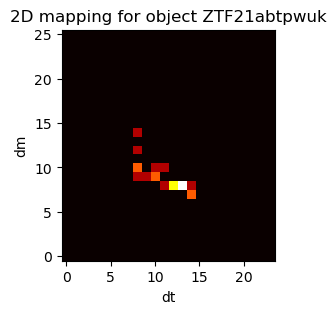

In [134]:
# plot first filter of first object
# print(dataset_final['oid_ztf'].tolist()[0])
x = 1005
print(dataset_final['labels_1'].tolist()[x])
fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title('2D mapping for object ' + object_list[x])
ax.set_xlabel('dt')
ax.set_ylabel('dm')
ax.imshow(dataset_dmdt[x, :, :, 0], cmap='hot', interpolation='nearest', origin='lower')
plt.show()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_189 (Conv2D)         (None, 24, 22, 32)        608       
                                                                 
 activation_349 (Activation  (None, 24, 22, 32)        0         
 )                                                               
                                                                 
 max_pooling2d_169 (MaxPool  (None, 12, 11, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_190 (Conv2D)         (None, 10, 9, 64)         18496     
                                                                 
 activation_350 (Activation  (None, 10, 9, 64)         0         
 )                                                               
                                                     

Epoch 1/500
8/8 [==============================] - 0s 29ms/step - loss: 5.7988 - accuracy: 0.1996 - val_loss: 4.4745 - val_accuracy: 0.3889
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 2.8366 - accuracy: 0.4071 - val_loss: 4.2420 - val_accuracy: 0.4306
Epoch 3/500
8/8 [==============================] - 0s 19ms/step - loss: 2.3053 - accuracy: 0.4369 - val_loss: 4.1827 - val_accuracy: 0.4259
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 1.9265 - accuracy: 0.4399 - val_loss: 3.9313 - val_accuracy: 0.4282
Epoch 5/500
8/8 [==============================] - 0s 19ms/step - loss: 1.8449 - accuracy: 0.4409 - val_loss: 3.5885 - val_accuracy: 0.4306
Epoch 6/500
8/8 [==============================] - 0s 19ms/step - loss: 1.7700 - accuracy: 0.4489 - val_loss: 3.3954 - val_accuracy: 0.4398
Epoch 7/500
8/8 [==============================] - 0s 18ms/step - loss: 1.7091 - accuracy: 0.4578 - val_loss: 3.2063 - val_accuracy: 0.4398
Epoch 8/500
8/8 [===

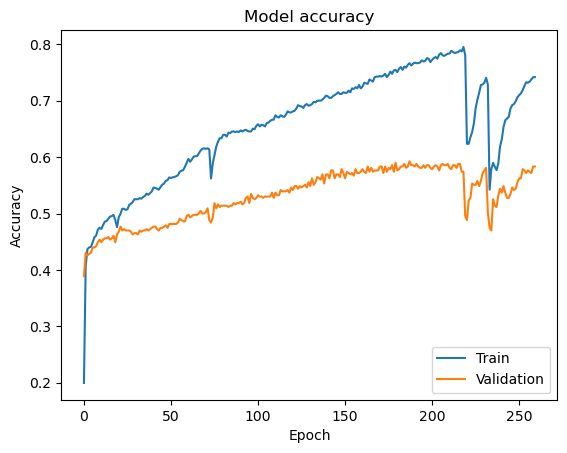

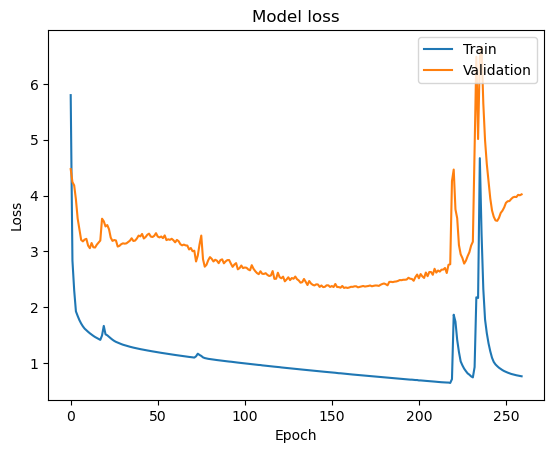

14/14 [==============================] - 0s 2ms/step


In [206]:
# Create a simple CNN model to classify objects based on their 2D mapping

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(26, 24, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

model.summary()

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model, it is a multi-classification problem
model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)


# Train the model
model.fit(X_train, y_train_encoded, batch_size=128, epochs=500, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

#plot the training and validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#plot the training and validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Make predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)


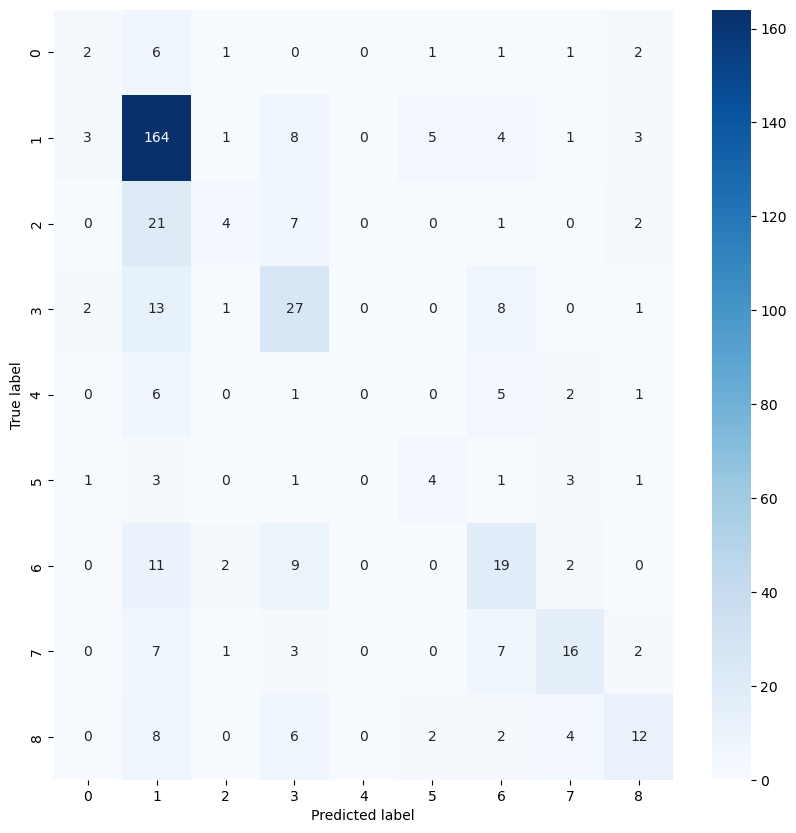

                   precision    recall  f1-score   support

            AMCVn       0.25      0.14      0.18        14
dwarf_nova_SU_UMa       0.69      0.87      0.77       189
 dwarf_nova_U_Gem       0.40      0.11      0.18        35
 dwarf_nova_Z_Cam       0.44      0.52      0.47        52
        int_polar       0.00      0.00      0.00        15
             nova       0.33      0.29      0.31        14
        nova_like       0.40      0.44      0.42        43
 nova_like_VY_Scl       0.55      0.44      0.49        36
            polar       0.50      0.35      0.41        34

         accuracy                           0.57       432
        macro avg       0.39      0.35      0.36       432
     weighted avg       0.53      0.57      0.54       432



In [207]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# get classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=enc.classes_))

